In [1]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import os

from torchcontrib.optim import SWA

from apoNN.src.datasets import ApogeeDataset

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

In [2]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)

lower_temp_cut = allStar["Teff"]>0
lower_g_cut = allStar["logg"]>0
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500



combined_cut =  snr_cut & snr_highcut & lower_g_cut & lower_temp_cut
cut_allStar = allStar[combined_cut]

with open("temp_idxs","rb") as f:
    idxs = pickle.load(f)
    
    
cut_allStar = cut_allStar[idxs]

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


In [3]:
pickled_dataset = ApogeeDataset(filename= "all_aspcap",outputs = ["aspcap","mask2","physical","idx"])

In [4]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/no_cut/ae_800.p")

In [5]:
def get_z(idx,dataset):
    _,z = autoencoder(dataset[idx][0].to(device).unsqueeze(0))
    return z

def get_v(idx,dataset,feedforward):
    _,z = autoencoder(dataset[idx][0].to(device).unsqueeze(0))
    v = feedforward(z)
    return v

In [6]:
n_datapoints = 10000

In [7]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE"] 
abundances_raw = np.array([cut_allStar[param] for param in considered_parameters])[:,:n_datapoints].T


In [8]:
z_array = np.array([get_z(i,pickled_dataset).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()
z_calibrated = (z_array- np.mean(z_array,axis=0)).T

#abundances_raw = np.array([cut_allStar["Teff"],cut_allStar["logg"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["C_FE"],cut_allStar["Na_FE"],cut_allStar["Mg_FE"],cut_allStar["Si_FE"],cut_allStar["S_FE"],cut_allStar["Al_FE"],cut_allStar["P_FE"]])[:,:n_datapoints].T
abundances_array = (abundances_raw-np.min(abundances_raw,axis=0))/(np.max(abundances_raw,axis=0)-np.min(abundances_raw,axis=0)).T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T

In [9]:
def undo_scaling(calibrated, raw, intermediate):
    return ((calibrated.T+np.mean(intermediate,axis=0))*((np.max(raw,axis=0)-np.min(raw,axis=0)).T)+np.min(raw,axis=0)).T

In [10]:
#filtered_idxs = (abundances_raw[:,0]<5500) & (abundances_raw[:,1]<5)
filtered_idxs = np.random.choice(a=[False, True], size=len(abundances_raw[:,1]), p=[0.99, 0.01])


In [11]:
W_est =np.dot(abundances_calibrated,np.linalg.pinv(z_calibrated))
#W_est =np.dot(abundances_calibrated[:,filtered_idxs],np.linalg.pinv(z_calibrated[:,filtered_idxs]))
abundances_calibrated_est = np.dot(W_est,z_calibrated)


In [12]:
abundances_uncalibrated = undo_scaling(abundances_calibrated,abundances_raw,abundances_array)
abundances_uncalibrated_est = undo_scaling(abundances_calibrated_est,abundances_raw,abundances_array)


(3000, 9000)

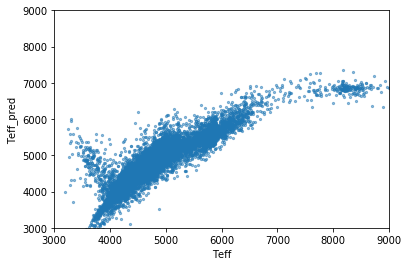

In [13]:
idx = 0
plt.scatter(abundances_uncalibrated[idx],abundances_uncalibrated_est[idx],s=5,alpha=0.5)
#plt.plot([3000,9000],[3000,9000],c="red")
plt.xlabel(f"{considered_parameters[idx]}")
plt.ylabel(f"{considered_parameters[idx]}_pred")
plt.xlim(3000,9000)
plt.ylim(3000,9000)

(0, 5)

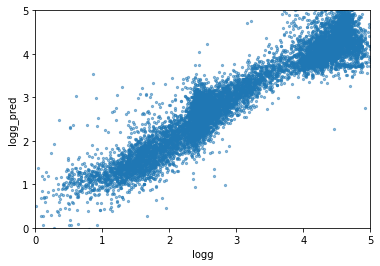

In [14]:
idx = 1
plt.scatter(abundances_uncalibrated[idx],abundances_uncalibrated_est[idx],s=5,alpha=0.5)
#plt.plot([3000,9000],[3000,9000],c="red")
plt.xlabel(f"{considered_parameters[idx]}")
plt.ylabel(f"{considered_parameters[idx]}_pred")
plt.xlim(0,5)
plt.ylim(0,5)

(3000, 9000)

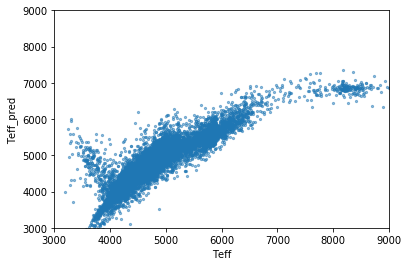

In [15]:
idx = 0
plt.scatter(abundances_uncalibrated[idx],abundances_uncalibrated_est[idx],s=5,alpha=0.5)
#plt.plot([3000,9000],[3000,9000],c="red")
plt.xlabel(f"{considered_parameters[idx]}")
plt.ylabel(f"{considered_parameters[idx]}_pred")
plt.xlim(3000,9000)
plt.ylim(3000,9000)

(0, 5)

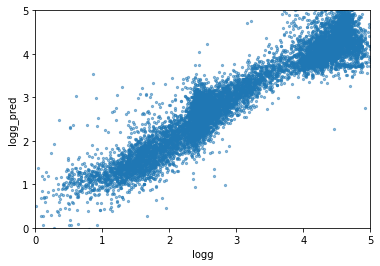

In [16]:
idx = 1
plt.scatter(abundances_uncalibrated[idx],abundances_uncalibrated_est[idx],s=5,alpha=0.5)
#plt.plot([3000,9000],[3000,9000],c="red")
plt.xlabel(f"{considered_parameters[idx]}")
plt.ylabel(f"{considered_parameters[idx]}_pred")
plt.xlim(0,5)
plt.ylim(0,5)

(0, 5)

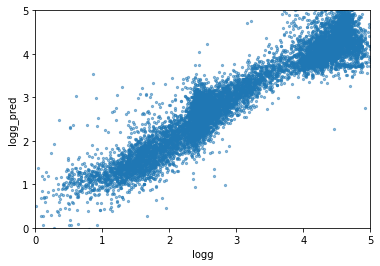

In [17]:
idx = 1
plt.scatter(abundances_uncalibrated[idx],abundances_uncalibrated_est[idx],s=5,alpha=0.5)
#plt.plot([3000,9000],[3000,9000],c="red")
plt.xlabel(f"{considered_parameters[idx]}")
plt.ylabel(f"{considered_parameters[idx]}_pred")
plt.xlim(0,5)
plt.ylim(0,5)

(6.0, -0.1)

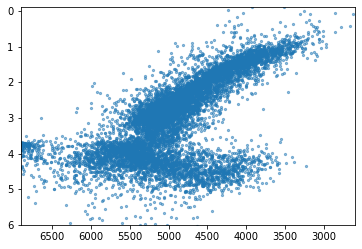

In [18]:
plt.scatter(abundances_uncalibrated_est[0],abundances_uncalibrated_est[1],s=5,alpha=0.5)
plt.xlim(6900,2600)
plt.ylim(6.0,-0.1)

(6.0, -0.1)

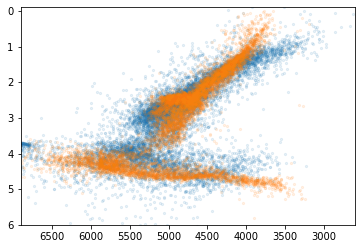

In [19]:
plt.scatter(abundances_uncalibrated_est[0],abundances_uncalibrated_est[1],s=5,alpha=0.1)
plt.scatter(abundances_uncalibrated[0],abundances_uncalibrated[1],s=5,alpha=0.1)

plt.xlim(6900,2600)
plt.ylim(6.0,-0.1)

(6.0, -0.1)

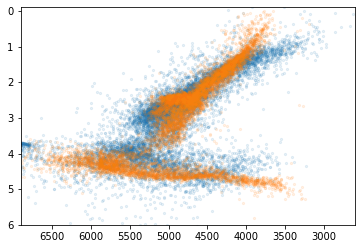

In [20]:
plt.scatter(abundances_uncalibrated_est[0],abundances_uncalibrated_est[1],s=5,alpha=0.1)
plt.scatter(abundances_uncalibrated[0],abundances_uncalibrated[1],s=5,alpha=0.1)

plt.xlim(6900,2600)
plt.ylim(6.0,-0.1)

(6.0, -0.1)

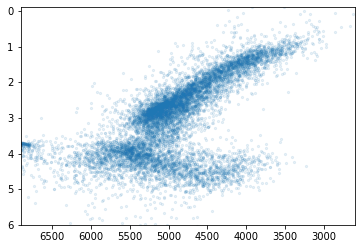

In [21]:
plt.scatter(abundances_uncalibrated_est[0],abundances_uncalibrated_est[1],s=5,alpha=0.1)
#plt.scatter(abundances_uncalibrated[0],abundances_uncalibrated[1],s=5,alpha=0.1)

plt.xlim(6900,2600)
plt.ylim(6.0,-0.1)

(6.0, -0.1)

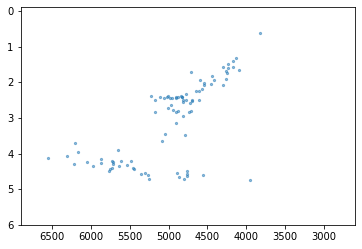

In [22]:
plt.scatter(abundances_uncalibrated[0][filtered_idxs],abundances_uncalibrated[1][filtered_idxs],s=5,alpha=0.5)
plt.xlim(6900,2600)
plt.ylim(6.0,-0.1)